<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/cursivetransformer_dictionary_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cursive Transformer Mechanistic Interpretability

The purpose of this notebook is to apply the techniques of mechanistic interpretability, in particular dictionary learning, to our cursive transformer. The goal of this exercise is two-fold:
1. Attempt to gain insight into the structure and orientation of the features being learned by the model, in particular in the cross-attention and feed-forward layers
2. More generally become familiar with the latest ME techniques, as they can easily transfer to be applied beyond the scope of this project to essentially ANY transformer-based model

To this end, we will reference the following resources throughout this document:
- https://transformer-circuits.pub/2023/monosemantic-features
- https://www.alignmentforum.org/posts/fKuugaxt2XLTkASkk/open-source-replication-and-commentary-on-anthropic-s
- https://colab.research.google.com/drive/1u8larhpxy8w4mMsJiSBddNOzFGj7_RTn?usp=sharing
- https://github.com/TransformerLensOrg/TransformerLens
- https://arena3-chapter1-transformer-interp.streamlit.app/

## TODO
1. Train the autoencoder

# Setup

In [ ]:
!python3 -V

## Dependencies

In [ ]:
# Install necessary packages
!python3 -V

!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

# Login to Weights & Biases (replace 'your_api_key' with your actual API key)
import wandb
wandb.login()

## Imports

In [1]:
import sys
sys.path.append('/content/cursivetransformer')  # Adjust the path if necessary

# Import cursivetransformer modules
from cursivetransformer.model import get_all_args, get_checkpoint
from cursivetransformer.data import create_datasets

# Import other necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gradio as gr
import pprint
import json
from datasets import load_dataset
from IPython.display import HTML, display
from functools import partial
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from einops import rearrange

# Defining the Autoencoder

In [2]:
# Configuration for the autoencoder
cfg = {
    "seed": 49,
    "batch_size": 4096,
    "buffer_mult": 384,
    "lr": 1e-4,
    "num_tokens": int(2e9),
    "l1_coeff": 3e-4,
    "beta1": 0.9,
    "beta2": 0.99,
    "dict_mult": 8,
    "seq_len": 128,
    "d_mlp": None,  # To be set after loading the model
    "enc_dtype": "fp32",
    "remove_rare_dir": False,
}

cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}

class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to("cuda")

    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj

# Utils



### Get Reconstruction Loss

In [3]:
def get_recons_loss(num_batches=5, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    loss_list = []
    loss_fn = nn.CrossEntropyLoss()
    for i in range(num_batches):
        idx = torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]
        tokens = all_tokens[idx].to(model_device)
        context = all_contexts[idx].to(model_device)
        targets = all_targets[idx].to(model_device)

        # Capture MLP activations
        mlp_activations = []

        def capture_mlp_activations(module, input, output):
            mlp_activations.append(output.detach())

        # Register the hook on the MLP output layer
        mlp_layer = model.transformer.h[0].mlp.c_proj  # Adjust layer index as needed
        hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

        # Forward pass without hooks
        logits, loss = model(tokens, context, targets=targets)
        loss = loss.item()

        # Remove the hook
        hook_handle.remove()

        # Get the activations
        mlp_acts = mlp_activations[0]  # Shape: [batch_size, seq_len, d_mlp]

        # Flatten activations
        mlp_acts_flattened = mlp_acts.reshape(-1, cfg["d_mlp"])

        # Reconstruct activations using encoder
        loss_enc, x_reconstruct, hidden_acts, l2_loss, l1_loss = local_encoder(mlp_acts_flattened)

        # Reconstructed activations reshaped back to original shape
        reconstructed_acts = x_reconstruct.view_as(mlp_acts)

        # Define the hook to replace activations
        def reconstruction_hook(module, input, output):
            return reconstructed_acts

        # Register the reconstruction hook
        hook_handle = mlp_layer.register_forward_hook(reconstruction_hook)
        # Forward pass with reconstructed activations
        logits_recons, loss_recons = model(tokens, context, targets=targets)
        recons_loss = loss_recons.item()
        hook_handle.remove()

        # Zero ablation
        def zero_ablation_hook(module, input, output):
            return torch.zeros_like(output)

        hook_handle = mlp_layer.register_forward_hook(zero_ablation_hook)
        logits_zero_abl, loss_zero_abl = model(tokens, context, targets=targets)
        zero_abl_loss = loss_zero_abl.item()
        hook_handle.remove()

        loss_list.append((loss, recons_loss, zero_abl_loss))
    losses = torch.tensor(loss_list)
    loss, recons_loss, zero_abl_loss = losses.mean(0).tolist()

    print(f"loss: {loss:.4f}, recons_loss: {recons_loss:.4f}, zero_abl_loss: {zero_abl_loss:.4f}")
    score = ((zero_abl_loss - recons_loss) / (zero_abl_loss - loss))
    print(f"Reconstruction Score: {score:.2%}")
    return score, loss, recons_loss, zero_abl_loss

### Get Frequencies

In [4]:
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(local_encoder.d_hidden, dtype=torch.float32).cuda()
    total = 0
    for i in tqdm.trange(num_batches):
        idx = torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]
        tokens = all_tokens[idx].to(model_device)
        context = all_contexts[idx].to(model_device)

        mlp_activations = []

        def capture_mlp_activations(module, input, output):
            mlp_activations.append(output.detach())

        # Register the hook on the MLP output layer
        mlp_layer = model.transformer.h[0].mlp.c_proj  # Adjust layer index as needed
        hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

        # Forward pass
        logits, _ = model(tokens, context)
        # Remove the hook
        hook_handle.remove()

        # Get the activations
        mlp_acts = mlp_activations[0]  # Shape: [batch_size, seq_len, d_mlp]
        mlp_acts_flattened = mlp_acts.reshape(-1, cfg["d_mlp"])

        # Pass through encoder
        hidden = local_encoder(mlp_acts_flattened)[2]  # Get the activations

        act_freq_scores += (hidden > 0).sum(0)
        total += hidden.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead", num_dead.item())
    return act_freq_scores


## Visualise Feature Utils

In [17]:
from html import escape
import colorsys
from IPython.display import display, HTML

SPACE = "·"
NEWLINE = "↩"
TAB = "→"



def create_html(strings, values, max_value=None, saturation=0.5, allow_different_length=False, return_string=False):
    # Escape strings to deal with tabs, newlines, etc.
    escaped_strings = [escape(s, quote=True) for s in strings]
    processed_strings = [
        s.replace("\n", f"{NEWLINE}<br/>").replace("\t", f"{TAB}&emsp;").replace(" ", "&nbsp;")
        for s in escaped_strings
    ]

    if isinstance(values, torch.Tensor) and len(values.shape) > 1:
        values = values.flatten().tolist()

    if not allow_different_length:
        assert len(processed_strings) == len(values)

    # Scale values
    if max_value is None:
        max_value = max(max(values), -min(values)) + 1e-3
    scaled_values = [v / max_value * saturation for v in values]

    # Create HTML
    html = ""
    for i, s in enumerate(processed_strings):
        if i < len(scaled_values):
            v = scaled_values[i]
        else:
            v = 0
        if v < 0:
            hue = 0  # Red in HSV
        else:
            hue = 0.66  # Blue in HSV
        rgb_color = colorsys.hsv_to_rgb(
            hue, v, 1
        )
        hex_color = "#%02x%02x%02x" % (
            int(rgb_color[0] * 255),
            int(rgb_color[1] * 255),
            int(rgb_color[2] * 255),
        )
        html += f'<span style="background-color: {hex_color}; border: 1px solid lightgray; font-size: 16px; border-radius: 3px;">{s}</span>'
    if return_string:
        return html
    else:
        display(HTML(html))

def basic_feature_vis(feature_index, max_val=0):
    feature_in = encoder.W_enc[:, feature_index]
    feature_bias = encoder.b_enc[feature_index]

    # Get a sample stroke sequence and context from the dataset
    x, c, _ = test_dataset[0]  # You can choose any index or randomize
    tokens = x.unsqueeze(0).to(model_device)  # Stroke tokens
    context = c.unsqueeze(0).to(model_device)  # Context tokens

    # Capture MLP activations
    mlp_activations = []

    def capture_mlp_activations(module, input, output):
        mlp_activations.append(output.detach())

    # Register the hook
    mlp_layer = model.transformer.h[0].mlp.c_proj
    hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

    # Forward pass
    logits, _ = model(tokens, context)
    # Remove the hook
    hook_handle.remove()

    # Get the activations
    mlp_acts = mlp_activations[0][0].cpu()  # Shape: [seq_len, d_mlp]
    feature_acts = F.relu((mlp_acts - encoder.b_dec.cpu()) @ feature_in.cpu() + feature_bias.cpu())
    if max_val == 0:
        max_val = max(1e-7, feature_acts.max().item())

    # Visualization
    tokens_str = ['[Stroke]' for _ in range(tokens.shape[1])]

    return basic_token_vis_make_str(tokens_str, feature_acts, max_val)


def basic_token_vis_make_str(strings, values, max_val=None):
    if not isinstance(strings, list):
        strings = list(strings)
    values = values.detach().numpy()
    if max_val is None:
        max_val = values.max()
    header_string = f"<h4>Max Range <b>{values.max():.4f}</b> Min Range: <b>{values.min():.4f}</b></h4>"
    header_string += f"<h4>Set Max Range <b>{max_val:.4f}</b></h4>"
    body_string = create_html(strings, values, max_value=max_val, return_string=True)
    return header_string + body_string

def list_flatten(nested_list):
    return [x for y in nested_list for x in y]

def make_token_df(tokens, len_prefix=5, len_suffix=1):
    str_tokens = [idx2char.get(t.item(), '') for t in tokens]
    unique_token = [f"{s}/{i}" for i, s in enumerate(str_tokens)]

    context = []
    batch = []
    pos = []
    label = []
    for p in range(len(tokens)):
        prefix = "".join(str_tokens[max(0, p - len_prefix):p])
        if p == len(tokens) - 1:
            suffix = ""
        else:
            suffix = "".join(str_tokens[p + 1:min(len(tokens), p + 1 + len_suffix)])
        current = str_tokens[p]
        context.append(f"{prefix}|{current}|{suffix}")
        batch.append(0)  # Since we have a single batch
        pos.append(p)
        label.append(f"{0}/{p}")
    return pd.DataFrame(dict(
        str_tokens=str_tokens,
        unique_token=unique_token,
        context=context,
        batch=batch,
        pos=pos,
        label=label,
    ))

### Make Token DataFrame

In [6]:
def list_flatten(nested_list):
    return [x for y in nested_list for x in y]

def make_token_df(tokens, len_prefix=5, len_suffix=1):
    str_tokens = [str(t.item()) for t in tokens]
    unique_token = [f"{s}/{i}" for i, s in enumerate(str_tokens)]

    context = []
    batch = []
    pos = []
    label = []
    for p in range(len(tokens)):
        prefix = "".join(str_tokens[max(0, p - len_prefix):p])
        if p == len(tokens) - 1:
            suffix = ""
        else:
            suffix = "".join(str_tokens[p + 1:min(len(tokens) - 1, p + 1 + len_suffix)])
        current = str_tokens[p]
        context.append(f"{prefix}|{current}|{suffix}")
        batch.append(0)  # Since we have a single batch
        pos.append(p)
        label.append(f"{0}/{p}")
    return pd.DataFrame(dict(
        str_tokens=str_tokens,
        unique_token=unique_token,
        context=context,
        batch=batch,
        pos=pos,
        label=label,
    ))

## Loading the Model

In [7]:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'  # Replace with your actual run ID
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'  # Replace with your dataset name
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

model, optimizer, scheduler, step, best_loss = get_checkpoint(args)


cfg["d_mlp"] = args.n_embd  # Assuming n_embd is the MLP dimension
args

Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples
Number of Transformer parameters: 368064
Model #params: 397184
Loaded model from local path: best_checkpoint.pt


namespace(max_steps=110000,
          print_every=100,
          log_every=2500,
          lr_decay=0.333,
          step_lr_every=33000,
          device='cuda',
          seed=42,
          n_layer=4,
          n_embd=64,
          n_embd2=64,
          n_ctx_head=4,
          learning_rate=0.01,
          weight_decay=0.0001,
          batch_size=32,
          train_size=497000,
          test_size=3000,
          num_words=4,
          max_seq_length=1000,
          augment=True,
          ablate_cross_attention=False,
          downsample_mean=0.65,
          downsample_width=0.1,
          add_digits=True,
          alphabet=' enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"\'(BCQLMWYU,ZF!DXV?KPGJ',
          dataset_name='bigbank',
          wandb_project='bigbank_experiments',
          wandb_entity='sam-greydanus',
          wandb_run_name='cursivetransformer_dictionary_learning',
          wandb_api_key=None,
          load_from_run_id='6le6tujz',
          sample_only=True,


In [8]:
model_device = 'cuda'
model = model.to(model_device)
model = model.eval()  # Set model to evaluation mode

# Loading Data

In [9]:
# Prepare data
batch_size = cfg["model_batch_size"]
num_samples = 1000  # Adjust based on your dataset size
stroke_seqs = []
contexts = []

for i in range(num_samples):
    x, c, y = test_dataset[i]
    stroke_seqs.append(x)
    contexts.append(c)

all_tokens = torch.stack(stroke_seqs)
all_contexts = torch.stack(contexts)

# Analysis



## Initialize the Autoencoder

In [10]:
encoder = AutoEncoder(cfg)

# Train the Autoencoder

In [11]:
def train_sae(model, encoder, num_batches=100, batch_size=128):
    optimizer = torch.optim.Adam(encoder.parameters(), lr=cfg['lr'], betas=(cfg['beta1'], cfg['beta2']))

    for batch in tqdm.tqdm(range(num_batches)):
        optimizer.zero_grad()

        # Sample data
        idx = torch.randperm(len(all_tokens))[:batch_size]
        tokens = all_tokens[idx].to(model_device)
        contexts = all_contexts[idx].to(model_device)

        # Capture MLP activations
        mlp_activations = []
        def capture_mlp_activations(module, input, output):
            mlp_activations.append(output.detach())

        # Register the hook
        mlp_layer = model.transformer.h[0].mlp.c_proj
        hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

        # Forward pass
        with torch.no_grad():
            _ = model(tokens, contexts)

        # Remove the hook
        hook_handle.remove()

        # Get the activations
        mlp_acts = mlp_activations[0].reshape(-1, cfg["d_mlp"])

        # Pass through encoder
        loss, _, _, l2_loss, l1_loss = encoder(mlp_acts)

        # Backward pass
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            print(f"Batch {batch}, Loss: {loss.item():.4f}, L2 Loss: {l2_loss.item():.4f}, L1 Loss: {l1_loss.item():.4f}")

    print("SAE training completed.")

# Train the SAE
train_sae(model, encoder)

  0%|          | 0/100 [00:00<?, ?it/s]

Batch 0, Loss: 148600.3125, L2 Loss: 68905.7578, L1 Loss: 79694.5469
Batch 10, Loss: 136006.0781, L2 Loss: 56023.0664, L1 Loss: 79983.0156
Batch 20, Loss: 119153.3828, L2 Loss: 41808.9766, L1 Loss: 77344.4062
Batch 30, Loss: 102777.5859, L2 Loss: 30336.7734, L1 Loss: 72440.8125
Batch 40, Loss: 98984.3828, L2 Loss: 25417.9688, L1 Loss: 73566.4141
Batch 50, Loss: 87708.1250, L2 Loss: 20074.7910, L1 Loss: 67633.3359
Batch 60, Loss: 80645.4844, L2 Loss: 16945.4043, L1 Loss: 63700.0820
Batch 70, Loss: 77531.1094, L2 Loss: 15202.6943, L1 Loss: 62328.4141
Batch 80, Loss: 74130.2969, L2 Loss: 13975.5703, L1 Loss: 60154.7266
Batch 90, Loss: 69722.4375, L2 Loss: 12990.1641, L1 Loss: 56732.2773
SAE training completed.


## Using the Autoencoder

In [12]:
# Prepare data
batch_size = cfg["model_batch_size"]
num_samples = 1000  # Adjust based on your dataset size
stroke_seqs = []
contexts = []
targets = []

for i in range(num_samples):
    x, c, y = test_dataset[i]
    stroke_seqs.append(x)
    contexts.append(c)
    targets.append(y)

all_tokens = torch.stack(stroke_seqs)
all_contexts = torch.stack(contexts)
all_targets = torch.stack(targets)

# Define hook name based on your model's architecture
mlp_hook_name = 'transformer.h.0.mlp.c_proj'  # Adjust as per your model

# Run the reconstruction loss function
_ = get_recons_loss(num_batches=5, local_encoder=encoder)

loss: 1.1181, recons_loss: 8.6318, zero_abl_loss: 14.6293
Reconstruction Score: 44.39%


## Get Frequencies

  0%|          | 0/25 [00:00<?, ?it/s]

Num dead 0.0


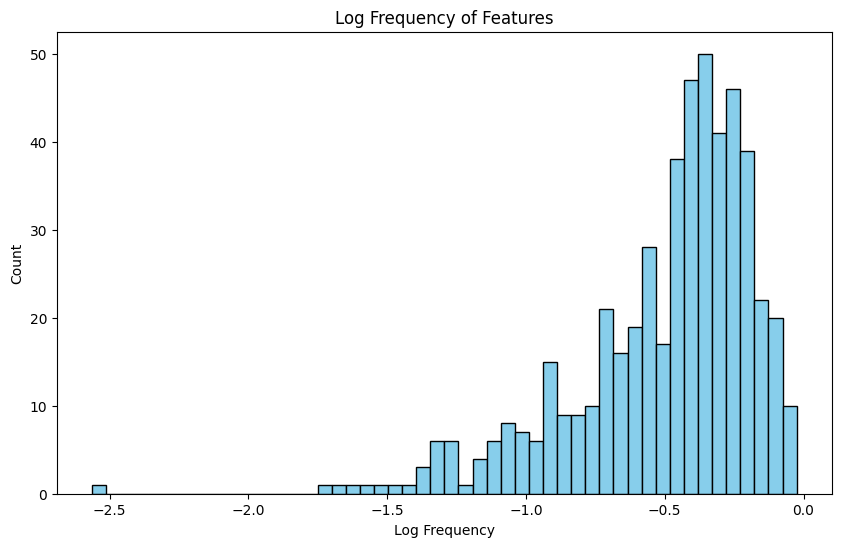

In [13]:
freqs = get_freqs(num_batches=25, local_encoder=encoder)

# Add 1e-6.5 so that dead features show up as log_freq -6.5
log_freq = (freqs + 10 ** -6.5).log10().cpu().numpy()
plt.figure(figsize=(10, 6))
plt.hist(log_freq, bins=50, color='skyblue', edgecolor='black')
plt.title("Log Frequency of Features")
plt.xlabel("Log Frequency")
plt.ylabel("Count")
plt.show()

## Interpreting A Feature

Let's investigate a non-rare feature, for example, `feature_id = 7`.

In [18]:
import pandas as pd

feature_id = 7  # Change as needed
batch_size = 128  # Adjust as needed

print(f"Feature freq: {freqs[feature_id].item():.4f}")

# Get activations
idx = torch.randperm(len(all_tokens))[:batch_size]
tokens = all_tokens[idx].to(model_device)
contexts = all_contexts[idx].to(model_device)
targets = all_targets[idx].to(model_device)

mlp_activations = []

def capture_mlp_activations(module, input, output):
    mlp_activations.append(output.detach())

# Register the hook
mlp_layer = model.transformer.h[0].mlp.c_proj
hook_handle = mlp_layer.register_forward_hook(capture_mlp_activations)

# Forward pass
logits, _ = model(tokens, contexts)
# Remove the hook
hook_handle.remove()

# Get the activations
mlp_acts = mlp_activations[0]  # Shape: [batch_size, seq_len, d_mlp]
mlp_acts_flattened = mlp_acts.reshape(-1, cfg["d_mlp"])

# Pass through encoder
loss_enc, x_reconstruct, hidden_acts, l2_loss, l1_loss = encoder(mlp_acts_flattened)
print("hidden_acts.shape", hidden_acts.shape)

# Create token dataframe
token_df = make_token_df(tokens.cpu().flatten())
token_df["feature"] = hidden_acts[:, feature_id].detach().cpu().numpy()
display(token_df.sort_values("feature", ascending=False).head(20))

Feature freq: 0.3856
hidden_acts.shape torch.Size([128000, 512])


,str_tokens,unique_token,context,batch,pos,label,feature
100938,,/100938,m||b,0,100938,0/100938,19.185392
115878,,/115878,jT||,0,115878,0/115878,18.702106
115832,,/115832,3Aj||j,0,115832,0/115832,18.427021
33978,,/33978,N7I||z,0,33978,0/33978,18.078495
24708,,/24708,0)4||6,0,24708,0/24708,18.064522
53722,,/53722,4I8||0,0,53722,0/53722,17.986200
77724,,/77724,83j||j,0,77724,0/77724,17.956104
1776,,/1776,0qI||9,0,1776,0/1776,17.907314
66768,,/66768,Rz4||.,0,66768,0/66768,17.892258
100650,,/100650,j0||,0,100650,0/100650,17.744642


## Visualizing Feature Activations

In [19]:
# Access the character-to-index and index-to-character mappings from the dataset
char2idx = train_dataset.stoi  # Character to index mapping
idx2char = train_dataset.itos  # Index to character mapping

# Define the tokenization function using the dataset's mapping
def tokenize_text(text):
    # Map each character to its index, default to PAD token (0) for unknown characters
    return [char2idx.get(ch, train_dataset.char_PAD_TOKEN) for ch in text]



def make_feature_vis_gradio(feature_id, starting_text=None):
    if starting_text is None:
        starting_text = "Sample text for visualization"

    with gr.Blocks() as demo:
        gr.HTML(value=f"Hacky Interactive Neuroscope for cursivetransformer")
        # The input elements
        with gr.Row():
            with gr.Column():
                text = gr.Textbox(label="Context Text", value=starting_text)
                feature_index = gr.Number(
                    label="Feature Index", value=feature_id, precision=0
                )
                max_val = gr.Number(label="Max Value", value=None)
                inputs = [text, feature_index, max_val]
        with gr.Row():
            with gr.Column():
                # The output element
                out = gr.HTML(label="Neuron Acts", value=basic_feature_vis(feature_id))
        def update_output(text, feature_index, max_val):
            return basic_feature_vis(text, int(feature_index), max_val)
        for inp in inputs:
            inp.change(update_output, inputs, out)
    demo.launch(share=True)

# Visualize the feature activations
starting_text = "Sample text to test feature activations in cursivetransformer"
make_feature_vis_gradio(feature_id, starting_text)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a3c04f1e10305d41f0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
